# Práctica de reconstrucción.  Parte II. Visión estéreo

Visión por Computador <br>
Practica 2.

Adrián Michelena Sanz

Alberto Miño Calero

Este enunciado está en el archivo "PracticaStereo.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* reconstruir puntos de una escena a partir de una serie de correspondencias manuales entre dos imágenes calibradas;
* determinar la geometría epipolar de un par de cámaras a partir de sus matrices de proyección;
* implementar la búsqueda automática de correspondencias que use las restricciones impuestas por la geometría epipolar, aplicando para ello métodos de cortes de grafos;
* realizar una reconstrucción densa de la escena.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV
* La librería PyMaxFlow

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica`` del tema de visión estéreo. Esta
carpeta contiene:
* Una serie de pares estéreo en el directorio images;
el sufijo del fichero indica si corresponde a la cámara
izquierda (_left) o a la derecha (_right). Bajo el
directorio ``rectif`` se encuentran varios pares estéreo
rectificados.
* Un conjunto de funciones auxiliares de ``Python`` en 
el módulo ``misc.py``. La descripción de las funciones
puede consultarse con el comando help o leyendo
su código fuente.
* El archivo ``cameras.npz`` con las matrices de proyección del par de cámaras con el que se tomaron todas las imágenes con prefijo minoru.

## Condiciones

* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Introducción

En los problemas de visión estéreo se supondrá la existencia de un par de cámaras calibradas cuyas matrices de proyección $\mathbf{P}_i$ vienen dadas
por $$\mathbf{P}_1 = \mathbf{K}_1\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_1 & \mathbf{t}_1\\ \mathbf{0}^T & 1
    \end{bmatrix},$$ $$\mathbf{P}_2 = \mathbf{K}_2\cdot\begin{bmatrix}\mathbf{I} & \mathbf{0}\end{bmatrix}\cdot
    \begin{bmatrix}
        \mathbf{R}_2 & \mathbf{t}_2\\ \mathbf{0}^T & 1
    \end{bmatrix}.$$
    
En esta práctica se usarán las matrices de proyección de
dos cámaras para determinar la posición tridimensional
de puntos de una escena. Esto es posible siempre que se
conozcan las proyecciones de cada punto en ambas cámaras. Desafortunadamente, esta información no suele estar
disponible y para obtenerla es preciso emplear el contenido
de las imágenes (sus píxeles) en un proceso de búsqueda
conocido como puesta en correspondencia. Conocer las matrices de proyección de las cámaras permite acotar el área
de búsqueda gracias a las restricciones que proporciona la
geometría epipolar.

In [4]:
# !pip install PyMaxflow
# uncomment to show results in a window
# %matplotlib tk
import cv2
import numpy as np
import scipy.misc as scpm
import scipy.ndimage as scnd
import matplotlib.pyplot as ppl
import numpy.linalg as npla
import maxflow.fastmin
import misc

""" ejecución en local """
drivePrefix = ""

""" ejecución google colab """
# !cp "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P3/misc.py" .
# from google.colab import drive
# drive.mount('/gdrive', force_remount=True)

# drivePrefix = "/gdrive/My Drive/Colab Notebooks/MUIA-ComputerVision/P3/"

## 1. Reconstrucción

Teniendo un conjunto de correspondencias entre dos
imágenes, con matrices de calibración $P_i$ conocidas, es
posible llevar a cabo una reconstrucción tridimensional de
dichos puntos. En el fichero ``cameras.npz`` se encuentran
las matrices de proyección para las dos cámaras. Para cargar
este fichero:

In [2]:
cameras = np.load(drivePrefix + "cameras.npz")
P1 = cameras["left"]
P2 = cameras["right"]

Todas las imágenes con el prefijo minoru comparten este par de matrices de proyección.

Leemos las imágenes y marcammos al menos seis puntos correspondientes en cada una de ella.

In [3]:
""" ejecución google colab """
# img1 = cv2.cvtColor(cv2.imread(drivePrefix + "/images/minoru_cube3_left.jpg"), cv2.COLOR_BGR2RGB)
# img2 = cv2.cvtColor(cv2.imread(drivePrefix + "/images/minoru_cube3_right.jpg"), cv2.COLOR_BGR2RGB)

""" ejecución en local """
img1 = cv2.cvtColor(cv2.imread(drivePrefix + "images/minoru_cube3_left.jpg"), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(drivePrefix + "images/minoru_cube3_right.jpg"), cv2.COLOR_BGR2RGB)

#ppl.imshow(img1)

(3, 6)


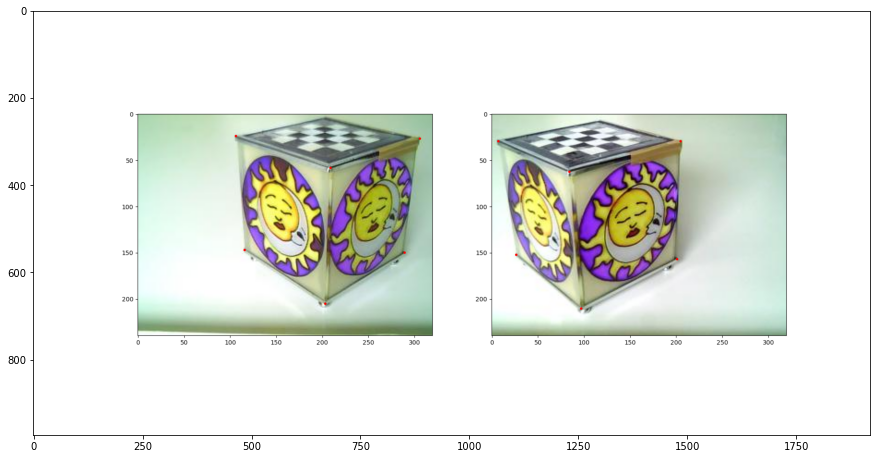

In [4]:
# pt1, pt2 = misc.askpoints(img1,img2)

pt1 = np.array([[105.9516129, 208.61827957, 305.60752688, 115.41397849, 202.94086022, 289.0483871],
                [23.28430108, 57.82193548, 26.12301075, 146.76817204, 204.96172043, 149.60688172],
                [1., 1., 1., 1., 1., 1.]
                ]
               )

pt2 = np.array([[6.7688172, 83.88709677, 204.53225806, 26.16666667, 96.66129032, 200.74731183],
                [28.96172043, 62.08, 28.96172043, 151.97247312, 210.16602151, 156.70365591],
                [1., 1., 1., 1., 1., 1.]
                ]
               )

print(pt1.shape)
ppl.figure(figsize=(15,10))
ppl.imshow(cv2.cvtColor(cv2.imread(drivePrefix + "Figure_1.png"), cv2.COLOR_BGR2RGB))
ppl.show()

In [5]:
print(pt1)
print(pt1[:2])

[[105.9516129  208.61827957 305.60752688 115.41397849 202.94086022
  289.0483871 ]
 [ 23.28430108  57.82193548  26.12301075 146.76817204 204.96172043
  149.60688172]
 [  1.           1.           1.           1.           1.
    1.        ]]
[[105.9516129  208.61827957 305.60752688 115.41397849 202.94086022
  289.0483871 ]
 [ 23.28430108  57.82193548  26.12301075 146.76817204 204.96172043
  149.60688172]]


**Ejercicio 1.** Implementa la función ``M = reconstruct(points1, points2, P1, P2)``
que, dados una serie de N puntos 2D ``points1`` de la primera imagen y sus 
N homólogos ``points2`` de la segunda imagen
(ambos en coordenadas homogéneas, 3 x N), y el par de matrices
de proyección P1 y P2 de la primera y la segunda cámara
respectivamente, calcule la reconstrucción tridimensional
de cada punto. De ese modo, si ``points1`` y
``points2`` son 3 × N , la matriz resultante M debe ser 4 × N.

El tipo de reconstrucción debe ser algebraico, no geométrico.


In [6]:
def reconstruct(points1, points2, P1, P2):
  """Reconstruct a set of points projected on two images."""
  points3d_hom = np.zeros((4,points1.shape[1]), dtype=np.float32)

  matrA = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
  matrW = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
  matrU = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]
  matrV = [[0,0,0,0],[0,0,0,0],[0,0,0,0],[0,0,0,0]]

  for i in range(0, points1.shape[1]):
    for j in range(0,2):
      if j==0:
        x = points1[0][i]
        y = points1[1][i]
        projMatrs = P1
      else:
        x = points2[0][i]
        y = points2[1][i]
        projMatrs = P2

      for k in range(0,4):
        matrA[j*2+0][k] = x * projMatrs[2][k] - projMatrs[0][k]
        matrA[j*2+1][k] = y * projMatrs[2][k] - projMatrs[1][k]

    matrU, matrW, matrV = np.linalg.svd(matrA, full_matrices=True)

    points3d_hom[0][i] = matrV[3][0]
    points3d_hom[1][i] = matrV[3][1]
    points3d_hom[2][i] = matrV[3][2]
    points3d_hom[3][i] = matrV[3][3]
  
  return points3d_hom

def hom_to_cart(points_hom):
    return points_hom[0:-1,:]/points_hom[-1]

Reconstruye los puntos marcados y pinta su estructura 3D.

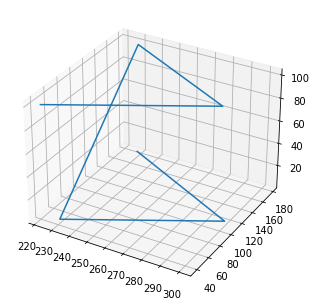

In [7]:
# reconstruct
mM = reconstruct(pt1[:2], pt2[:2], P1, P2)

# convert from homog to cartesian
mM_c = hom_to_cart(mM)

# plot 3D
misc.plot3D(mM_c[0,:],mM_c[1,:],mM_c[2,:])

**Ejercicio 2.**  Elige un par estéreo de las imágenes del conjunto "building" de la práctica de calibración y realiza una reconstrucción de un conjunto de puntos de dicho edificio estableciendo las correspondencias a mano.

**Ejercicio 3.**  Reproyecta los resultados de la reconstrucción
en las dos cámaras y dibuja las proyecciones sobre las
imágenes originales. Pinta también en otro color los puntos seleccionados manualmente. Comprueba si las proyecciones coinciden con los puntos marcados a mano. Comenta los resultados.
Para dibujar los puntos puedes usar la función plothom
de la práctica anterior o la versión que se distribuye con esta
práctica (misc.plothom).

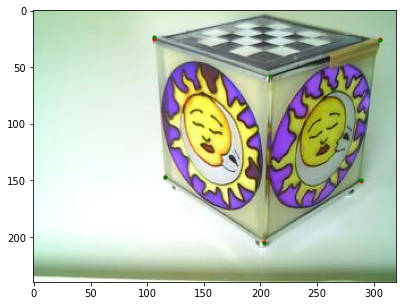

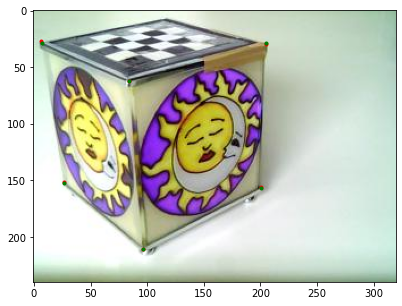

In [8]:
# Proyecto los puntos en ambas cámaras
proy1 = P1.dot(mM)
proy2 = P2.dot(mM)

# Pinto con misc.plothom()
ppl.figure(figsize=(10,5))
misc.plothom(proy1,'r.')
misc.plothom(pt1,'g.')
ppl.imshow(img1)
ppl.show()

ppl.figure(figsize=(10,5))
misc.plothom(proy2,'r.')
misc.plothom(pt2,'g.')
ppl.imshow(img2)
ppl.show()

En general, las proyecciones de los puntos (color verde) conciden con los establecidos a mano (color rojo), como era de esperar, aunque hay pequeñas desviaciones. En el caso de los puntos seleccionados en esta práctica, las imprecisiones se aprecian sobre todo en el caso de los puntos de los puntos de los extremos superior izquierdo y superior derecho. 

El motivo es evidente: al generar la reconstrucción de los puntos a partir de los escogidos a mano y de las matrices de proyección, se están embebiendo errores deribados tanto de dichas matrices como de la selección de puntos. Esto, unido proceso de reconstrucción algebraico, provoca las (pequeñas) inexactitudes que se observan. 

## 2. Geometría epipolar

La geometría epipolar deriva de las relaciones que aparecen en las proyecciones de una escena sobre un par de
cámaras. La matriz fundamental $\mathbf{F}$, que depende exclusivamente de la configuración de las cámaras y no de la escena
que éstas observan, es la representación algebráica de dicha
geometría: a partir de ella se pueden calcular los epipolos
y las líneas epipolares. La relación entre un par de cámaras
$\mathbf{P}_1$, $\mathbf{P}_2$ y la matriz fundamental es de n -a- 1 (salvo factor de
escala). Es decir, dadas dos cámaras calibradas, sólo tienen
una matriz fundamental (excepto un factor de escala); dada
una matriz fundamental existen infinitas configuraciones de
cámaras posibles asociadas a ella.

### 2.1 Estimación de la matriz fundamental

**Ejercicio 4.** Implementa la función ``F = projmat2f(P1, P2)``
que, dadas dos matrices de proyección, calcule la matriz
fundamental asociada a las mismas. $\mathbf{F}$ debe ser tal que,
si $m_1$ de la imagen 1 y $m_2$ de la imagen 2 están en
correspondencia, entonces $m_2^\top F m_1 = 0$.

In [9]:
def projmat2f(P1,P2):
  """ Calcula la matriz fundamental a partir de dos de proyeccion"""

  A = P1[:,:3]
  b = P1[:,3:4]
  B = P2[:,:3]
  d = P2[:,3:4]

  B_inv_d = npla.pinv(B) @ d
  A_inv_b = npla.pinv(A) @ b

  aux = B_inv_d - A_inv_b
  aux = skew(aux)

  F = npla.pinv(B.T) @ aux @ npla.pinv(A)

  return F

def skew(v):
  """
  this function returns a numpy array with the skew symmetric cross product matrix for v.
  the skew symmetric cross product matrix is defined such that
  np.cross(a, b) = np.dot(skew(a), b)

  :param v: An array like v to create the skew symmetric cross product matrix for
  :return: A numpy array of the skew symmetric cross product v
  """
  r = np.array([[0,        -v[2,0],   v[1,0]],
                [v[2,0],   0,         -v[0,0]],
                [-v[1,0],  v[0,0],    0]]
               )
  return r

In [10]:
F = projmat2f(P1,P2)

print("F:",F)

F: [[ 8.37918051e-09 -2.64352488e-06  8.61307712e-04]
 [ 8.17120601e-06  4.36740640e-06  1.37641120e-01]
 [-2.27541839e-03 -1.42176580e-01  7.61491838e-03]]


**Ejercicio 5** ¿Cómo es la matriz fundamental de dos cámaras
que comparten el mismo centro? (Por ejemplo, dos cámaras
que se diferencian sólo por una rotación.)

Si los dos centros de las cámaras son iguales, significa que C es el centro de la ambas P1 y P2. Entonces, 
$P1 \cdot C$ = 0, ya que al coincidir los dos centro, no existe una línea epipolar y por tanto no tenemos epipolos en las imágenes. De ello se deduce que F es la matriz cero en base a la deribación $F = [P1 \cdot C]_x P1 \cdot P2^+ $ (Hartley & Zisserman, 2004) porque $P1 \cdot C$ = 0. $P2^+$ es la pseudo-inversa de $P2$ tal que $P2 \cdot P2^+ = I$.

La matriz fundamental de dos cámaras con el mismo centro será, por tanto, la matriz nula.

### 2.2 Comprobación de F (OPCIONAL)

En los siguientes dos ejercicios vamos a comprobar que la matriz F estimada a partir de P1 y P2 es correcta.

**Ejercicio 6.** Comprueba que F es la matriz fundamental asociada a las cámaras ``P1`` y ``P2``. Para ello puedes utilizar el resultado 9.12, que aparece en la página 255 del libro Hartley, Zisserman. "Multipe View Geometry in Computer Vision." (sedond edition). Cambridge University Press, 2003.


Debido al ruido en las matrices de proyecto P1 y P2, la matriz $P2T\_F\_P1 = P2^T \cdot F \cdot P1$ no será anti simétrica pura, aunque si debe de tener, por lado valores cercanos a 0 en su diagonal. Por ello, se va a aplicar un threshold de $1.0 * 10^{-7}$ de forma que los valores inferiores (en valor absoluto) se considerarán iguales a 0.

In [11]:
P2T_F_P1 = P2.T @ F @ P1
print("Matriz P2TFP1\n",P2T_F_P1)
print("--------------------------------------------------------------------")
print("Matriz P2TFP1 transpuesta (serán ambas iguales porque la matriz es antisimétrica\n",P2T_F_P1.T)
print("--------------------------------------------------------------------")
P2T_F_P1_test = P2T_F_P1.copy()
super_threshold_indices = abs(P2T_F_P1_test) < 0.0000001
P2T_F_P1_test[super_threshold_indices] = 0
print("Matriz P2T_F_P1 anti-simétrica tras aplicar treshold de 1.0e-07 de equivalencia a 0\n",P2T_F_P1_test)
print("--------------------------------------------------------------------")

Matriz P2TFP1
 [[-1.15977466e-13 -7.03485803e-01 -6.00041642e+01  1.09871679e+04]
 [ 7.03485803e-01 -1.14452950e-15 -3.08433134e+00  1.98740801e+02]
 [ 6.00041642e+01  3.08433134e+00 -1.48519641e-13 -3.12199487e+04]
 [-1.09871679e+04 -1.98740801e+02  3.12199487e+04 -4.50508458e-08]]
--------------------------------------------------------------------
Matriz P2TFP1 transpuesta (serán ambas iguales porque la matriz es antisimétrica
 [[-1.15977466e-13  7.03485803e-01  6.00041642e+01 -1.09871679e+04]
 [-7.03485803e-01 -1.14452950e-15  3.08433134e+00 -1.98740801e+02]
 [-6.00041642e+01 -3.08433134e+00 -1.48519641e-13  3.12199487e+04]
 [ 1.09871679e+04  1.98740801e+02 -3.12199487e+04 -4.50508458e-08]]
--------------------------------------------------------------------
Matriz P2T_F_P1 anti-simétrica tras aplicar treshold de 1.0e-07 de equivalencia a 0
 [[ 0.00000000e+00 -7.03485803e-01 -6.00041642e+01  1.09871679e+04]
 [ 7.03485803e-01  0.00000000e+00 -3.08433134e+00  1.98740801e+02]
 [ 6.000

Ya se ha comprobado que los valores de su diagonal son 0. Ahora, para comprobar si el resto de valores cumplen con las propiedades que debe tener una matriz anti simétrica, vamos a sumarla con su transpuesta. Si fuera anti simétrica, el resultado debería ser la matriz nula. De nuevo, debido al ruido, los valores no serán en ningún caso exactamente nulos, pero sí deberán ser aproximadamente 0. Volveremos a aplicar un threshold de $1.0 * 10^{-7}$, suponiendo que en caso de estar por debajo de dicho valor, se puede considerar 0.

In [12]:
P2T_F_P1_test = P2T_F_P1_test + P2T_F_P1_test.T
print("Suma de P2T_F_P1 con su transpuesta\n",P2T_F_P1_test)
print("--------------------------------------------------------------------")
super_threshold_indices = abs(P2T_F_P1_test) < 0.0000001
P2T_F_P1_test[super_threshold_indices] = 0
print("Suma de M con su transpuesta tras aplicar treshold de 1.0e-07 de equivalencia a 0\n",P2T_F_P1_test)
print("--------------------------------------------------------------------")

Suma de P2T_F_P1 con su transpuesta
 [[ 0.00000000e+00 -4.68514116e-14 -2.84217094e-14  1.47338142e-10]
 [-4.68514116e-14  0.00000000e+00  7.99360578e-14  1.06012976e-11]
 [-2.84217094e-14  7.99360578e-14  0.00000000e+00  4.36557457e-11]
 [ 1.47338142e-10  1.06012976e-11  4.36557457e-11  0.00000000e+00]]
--------------------------------------------------------------------
Suma de M con su transpuesta tras aplicar treshold de 1.0e-07 de equivalencia a 0
 [[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]
--------------------------------------------------------------------


Efectivamente, tras las dos pruebas realizadas, y tal y como se podía intuir sin dificultados observando la matriz original $ P2T\_F\_P1 = P2^T \cdot F \cdot P1 $, se puede validar que F es la matriz fundamental asociada a las cámaras P1 y P2

También se puede comprobar geométricamente la bondad de una matriz F, si  las epipolares con ella estimadas pasan por el homólogo de un punto dado en una de las imágenes.

Dada la matriz fundamental $\mathbf{F}$ entre las cámaras 1 y 2,
se puede determinar, para un determinado punto $m_1$ en la
imagen de la cámara 1, cuál es la recta epipolar $l_2$ donde se
encontrará su homólogo en la cámara 2: $$l_2 = \mathbf{F} m_1.$$

Las siguientes dos funciones sirven para comprobar esta
propiedad. En primer lugar, se necesita una función que
dibuje rectas expresadas en coordenadas homogéneas, es
decir, la versión de plothom para rectas en lugar de puntos.

**Ejercicio 7.** Implementa la función ``plothline(line)``
que, dada una línea expresada en coordenadas homogéneas,
la dibuje.

In [13]:
def plothline(line, axes = None):
    """Plot a line given its homogeneous coordinates.
    
    Parameters
    ----------
    line : array_like
        Homogeneous coordinates of the line.
    axes : AxesSubplot
        Axes where the line should be plotted. If not given,
        line will be plotted in the active axis.
    """
    if axes == None:
        axes = ppl.gca()
    
    [x0, x1, y0, y1] = axes.axis()

    #     (x0, y0) ._____________________. (x1, y0)
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #              |                     |
    #     (x0, y1) .---------------------. (x1, y1)
 
    # Compute the intersection of the line with the image borders
    a,b,c = line[0], line[1], line[2] 
    
    ay = (x0 * a + c) / -b
    by = (x1 * a + c) / -b
        
    # Plot the line with axes.plot
    plotline = axes.plot([x0, x1], [ay, by], 'r-')
    
    axes.axis([x0, x1, y0, y1])
    return plotline

**Ejercicio 8.** Completa la función ``plot_epipolar_lines(image1, image2, F)``
que, dadas dos imágenes y la matriz fundamental que
las relaciona, pide al usuario puntos en la imagen 1 y
dibuje sus correspondientes epipolares en la imagen 2 usando ``plothline``.

In [14]:
def plot_epipolar_lines(image1, image2, F, gray):
    """Ask for points in one image and draw the epipolar lines for those points.
    
    Parameters
    ----------
    image1 : array_like
        First image.
    image2 : array_like
        Second image.
    F : array_like
        3x3 fundamental matrix from image1 to image2.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    
    if gray==1:
        ax1.imshow(image1,cmap='gray')
    else:
        ax1.imshow(image1)
        
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    
    if gray==1:
        ax2.imshow(image2,cmap='gray')
    else:
        ax2.imshow(image2)
        
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.hstack([np.array(point[0]), 1])
        ax1.plot(point[0], point[1], '.r')
        
        # TODO: Determine the epipolar line.
        line = F @ point
        
        # Plot the epipolar line with plothline (the parameter 'axes' should be ax2).
        plothline(line, axes=ax2)
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

Utiliza esta función con un par de imágenes llamándola
de dos formas diferentes: seleccionando puntos en la imagen
izquierda y dibujando las epipolares en la imagen derecha
y viceversa. Comprueba en ambos casos que las epipolares
siempre pasan por el punto de la segunda imagen correspondiente al seleccionado en la primera. Esto confirmara la corrección de la matriz F.

Añade dos figuras una que muestre la selección de puntos en
la imagen izquierda y las rectas correspondientes en la
imagen derecha, y otra que lo haga al revés. Indica para
ambos casos qué matriz fundamental has usado al llamar a
``plot_epipolar_lines``.

In [15]:
%matplotlib tk
# Llamamos a la función con img1 e img2, y usamos la matriz fundamental F
plot_epipolar_lines(img1, img2, F, 0)

In [16]:
# Llamamos a la función con img2 e img1, y usamos la matriz fundamental F.T
# Hay que utilizar la transpuesta porque la correspondencia va a ser de la 
# segunda a la primera, y F fue calculada tomando las imágenes en order img1 e img2
plot_epipolar_lines(img2, img1, F.T, 0)

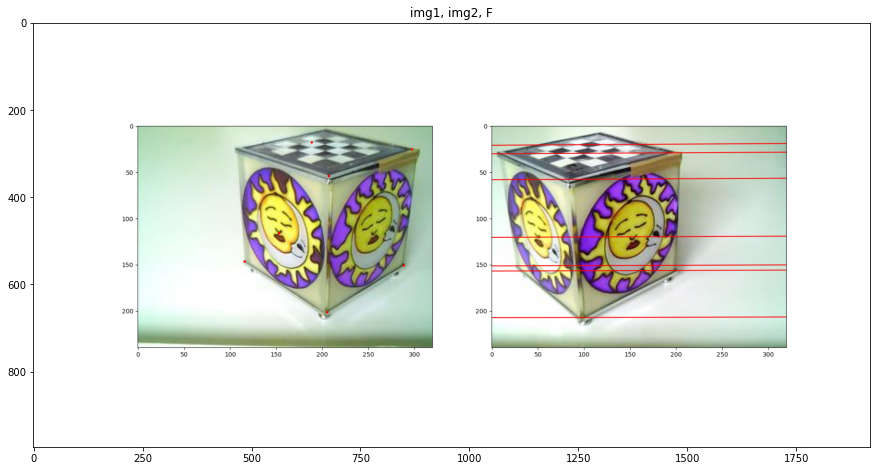

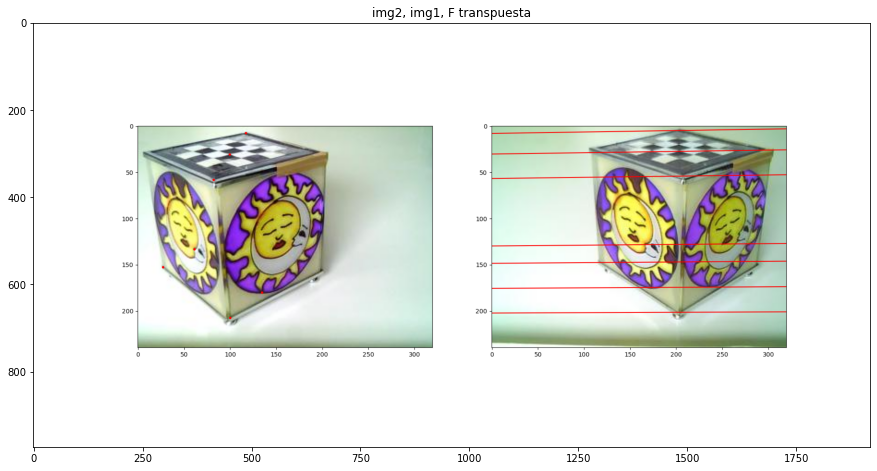

In [15]:
%matplotlib inline
# Resultado de las ejecuciones de ambas celdas anteriores
ppl.figure(figsize=(15,10))
ppl.title("img1, img2, F")
ppl.imshow(cv2.cvtColor(cv2.imread(drivePrefix + "Figure_2_Ej7-8_1.png"), cv2.COLOR_BGR2RGB))
ppl.show()

ppl.figure(figsize=(15,10))
ppl.title("img2, img1, F transpuesta")
ppl.imshow(cv2.cvtColor(cv2.imread(drivePrefix + "Figure_2_Ej7-8_2.png"), cv2.COLOR_BGR2RGB))
ppl.show()

##  3. Rectificación de imágenes

Es recomendable trabajar a partir de ahora con imágenes
en blanco y negro y con valores reales entre 0 y 1 para cada
uno de sus píxeles. Eso se puede conseguir con

In [16]:
img1 = misc.rgb2gray(img1/255.0)
img2 = misc.rgb2gray(img2/255.0)

La mayoría de algoritmos de puesta en correspondencia,
incluyendo el que se va a implementar en esta práctica,
requieren que las imágenes de entrada estén rectificadas.

Dos imágenes están rectificadas si sus correspondientes epipolares están alineadas horizontalmente. La rectificación de
imágenes facilita enormemente los algoritmos de puesta en
correspondencia, que pasan de ser problemas de búsqueda
bidimensional a problemas de búsqueda unidimensional
sobre filas de píxeles de las imágenes. En el material de
la práctica se han incluido dos funciones que rectifican
(mediante un método lineal) dos imágenes. La función
``H1, H2 = misc.projmat2rectify(P1, P2, imsize)``
devuelve, dadas las dos matrices de proyección y el tamaño de las imágenes en formato (filas,columnas), las
homografías que rectifican, respectivamente, la imagen 1
y la imagen 2. La función ``projmat2rectify`` hace uso
de ``projmat2f``, por lo que
es necesario que esta función esté disponible.

**Ejercicio 9.** Se tienen dos imágenes no rectificadas ``im1`` e
``im2``, y su matriz fundamental asociada $\mathbf{F}$ . Con el procedimiento explicado, se encuentran un par de homografías $\mathbf{H}_1$ y $\mathbf{H}_2$ que dan lugar a las imágenes rectificadas ``O1`` y ``O2``. ¿Cuál es la matriz fundamental $\mathbf{F}′$ asociada a estas dos imágenes? ¿Por qué?

Nota: F ′ depende exclusivamente de F , H1 y H2.

La rectificación de una imagen puede describirse como una transformación que envía los epipolos al
infinito, por lo tanto, las líneas epipolares se vuelven paralelas entre sí. Además, nos aseguramos de que los puntos correspondientes tengan la misma coordenada ${y}$ mediante el mapeado de los epipolos en la dirección ${e = (1,0,0)^T}$ o equivalentemente ${e = (e_u,0,0)^T}$.

La matriz fundamental para un par de imágenes rectificadas es:

\begin{equation}
  F'=
  \begin{bmatrix}
    0 & 0 & 0\\
    0 & 0 & -1\\
    0 & 1 & 0
  \end{bmatrix}
\end{equation}



La matriz $ F' = H_2^{-T} F H_1^{-1}$ se puede obtener del siguiente desarrollo:

Partiendo de igualdad que se ha visto en clase $ m_2^{T} F m_1 = 0 $, se puede escribir para el par de imágenes rectificadas que $ m_2'^{T} F' m_1' = 0 $, siendo $F'$ la matriz fundamental de dicho par de imágenes rectificadas. Teniendo en cuenta que $ m_2 = m_2' H_2^{-1} $ y $ m_1 = m_1' H_1^{-1} $, se pueden igualar ambas fórmulas, de forma que:
* $ m_2^{T} F m_1 = m_2'^{T} F' m_1' $
Si sustituimos $ m_2 = m_2' H_2^{-1} $ y $ m_1 = m_1' H_1^{-1} $ en lo anterior, nos quedamos con:


* $ (m_2' H_2^{-1})^{T} F (m_1' H_1^{-1}) = m_2'^{T} F' m_1' $


* $ H_2^{-T} m_2'^{T} F m_1' H_1^{-1} = m_2'^{T} F' m_1' $


A partir de la expresión última, podemos simplificar y quedanos con la fórmula inicial de $ F' = H_2^{-T} F H_1^{-1}$, en donde además deberá ser cumplirse al dividir por un escalar arbitrario (valor del elemento en la posición fila 3 columna 2), tal y como se indicó anteriormente al ser imágenes rectificadas:
\begin{equation}
  F'=
  \begin{bmatrix}
    0 & 0 & 0\\
    0 & 0 & -1\\
    0 & 1 & 0
  \end{bmatrix}
\end{equation}

**Ejercicio 10.** Rectifica el par de imágenes estéreo ``img1`` e ``img2`` y calcula
la matriz fundamental asociada a estas imágenes.

In [17]:
H1, H2 = misc.projmat2rectify(P1, P2, projmat2f, img1.shape)
O1, O2 = misc.rectify_images(img1, img2, H1, H2)

In [20]:
print("H1:\n",H1)
print("H2:\n",H2)

H1:
 [[ 1.55689447e+00  2.10202884e-02 -1.21453577e-15]
 [ 4.35212294e-02  2.71936782e+00 -1.45648207e-01]
 [ 5.87435810e-05  3.12785976e-05  9.89547558e-01]]
H2:
 [[ 1.50196875e+00 -9.39720932e-03  2.25533024e+00]
 [ 1.66452155e-02  2.66042744e+00  0.00000000e+00]
 [ 1.87847072e-05 -1.17528294e-07  1.00000000e+00]]


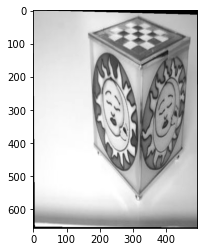

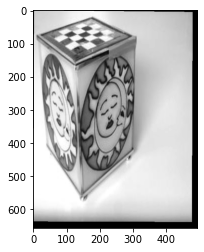

In [18]:
ppl.imshow(O1,cmap='gray')
ppl.figure()
ppl.imshow(O2,cmap='gray')

**Ejercicio 11.** Calcula y muestra la matriz fundamental de las imágenes
rectificadas. Justifica el resultado obtenido (mira la sección 9.3.1 del libro de Hartley y Zisserman, pág. 248 y 249).

In [18]:
# Calcular matriz fundamental con H1 y H2
Fr = npla.pinv(H2.T) @ F @ npla.pinv(H1)
# Dividimos por un escalar arbitrario para reducir sus grados de libertad
Fr = Fr/Fr[2,1]

print("Matriz fundamental de las 2 imágenes rectificadas\n",Fr)
print("--------------------------------------------------------------------")

Fr_test = Fr.copy()
super_threshold_indices = abs(Fr_test) < 0.0000001
Fr_test[super_threshold_indices] = 0
print("Matriz fundamental de las 2 imágenes rectificadas tras aplicar treshold de 1.0e-07 de equivalencia a 0\n",Fr_test)
print("--------------------------------------------------------------------")


Matriz fundamental de las 2 imágenes rectificadas
 [[ 2.36627570e-22 -7.65050515e-17  2.17941834e-15]
 [ 9.89927858e-17  3.90798478e-17 -1.00000000e+00]
 [-1.91016503e-15  1.00000000e+00  3.52785650e-12]]
--------------------------------------------------------------------
Matriz fundamental de las 2 imágenes rectificadas tras aplicar treshold de 1.0e-07 de equivalencia a 0
 [[ 0.  0.  0.]
 [ 0.  0. -1.]
 [ 0.  1.  0.]]
--------------------------------------------------------------------


El resultado obtenido coincide con lo que se ha explicado en el ejercicio 9, en donde se justifican los valores de la matriz F' (en este caso, Fr)

**Ejercicio 12.** Usa ``plot_epipolar_lines`` para dibujar varias líneas epiplares de las imágenes rectificadas. Muestra los resultados.

In [22]:
%matplotlib tk
plot_epipolar_lines(O1,O2,Fr,1)

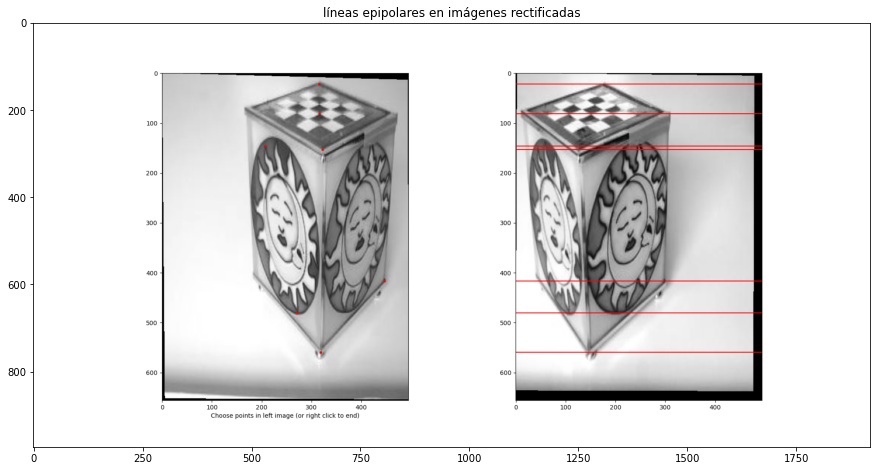

In [19]:
%matplotlib inline
ppl.figure(figsize=(15,10))
ppl.title("líneas epipolares en imágenes rectificadas")
ppl.imshow(cv2.cvtColor(cv2.imread(drivePrefix + "Figure_1_Ej12.png"), cv2.COLOR_BGR2RGB))
ppl.show()

## 4. Búsqueda de correspondencias

La búsqueda de correspondencias consigue establecer automáticamente las correspondencias de puntos entre dos
imágenes (lo que se ha hecho manualmente en el ejercicio 2)
haciendo uso de las restricciones que proporciona la geometría epipolar.

### 4.1 Cálculo de las medidas de similaridad

Una vez rectificadas las dos imágenes de un par estéreo,
se pueden buscar las correspondencias. Una matriz de disparidades $\mathbf{S}$ indica, para cada píxel de la imagen 1
rectificada, a cuántos píxeles de diferencia está su correspondencia
en la imagen 2 rectificada. En nuestra práctica, para simplificar el problema, vamos a considerar que los elementos
de $\mathbf{S}$ son enteros. Para el píxel en la posición $(x, y)$ en la
imagen 1, su correspondiente está en $(x + S[y, x], y)$ en la
imagen 2. Si $S[y, x] < 0$, la correspondencia está hacia la
izquierda; si $S[y, x] > 0$, la correspondencia está hacia la
derecha; si $S[y, x] = 0$, las coordenadas de los dos puntos
coinciden en ambas imágenes.

La búsqueda de correspondencias requiere ser capaz de
determinar el parecido visual entre píxeles de dos imágenes.
Si los píxeles $m_1$ y $m_2$ son visualmente parecidos, tienen
más probabilidad de estar en correspondencia que otros
que sean visualmente diferentes. Como la
apariencia (el nivel de gris) de un único píxel es propensa
al ruido y poco discriminativa, el elemento de puesta en
correspondencia será una ventana centrada en el píxel.
Dado un píxel $m$ de una imagen, llamaremos vecindad
del píxel de radio $K$ al conjunto de píxeles de la imagen que se encuentren dentro de una ventana de tamaño
$(2K + 1) × (2K + 1)$ píxeles centrada en $m$ . El número de
píxeles de una vecindad de radio $K$ es $N = (2K + 1)^2$.
Dadas dos vecindades $w_1$ y $w_2$ de dos píxeles, el parecido
visual entre ellas puede calcularse con la suma de *diferencias
al cuadrado (SSD)* de cada una de sus componentes
$$d_{SSD}(\mathbf{v}, \mathbf{w}) = \sum_{i=1}^N(\mathbf{v}_i - \mathbf{w}_i)^2.$$

La distancia $d_{SSD}$ es siempre positiva, es pequeña cuando
dos ventanas son visualmente parecidas y grande en caso
contrario.

**Ejercicio 13.** Implementa la función
``C = localssd(im1, im2, K)``
que calcula la suma de diferencias al cuadrado entre las
ventanas de radio K de la imagen 1 y la imagen 2. El
resultado debe ser una matriz del mismo tamaño que las
imágenes de entrada que contenga en cada punto el valor
de $d_{SSD}$ para la ventana de la imagen 1 y la ventana
de la imagen 2 centradas en él. Es decir, $C[i,j]$ debe
ser el resultado de $d_{SSD}$ para las ventanas centradas en
$im1[i,j]$ e $im2[i,j]$.

Para este ejercicio puede resultar útil la función
``scipy.ndimage.convolve``.

In [20]:
def localssd(im1, im2, K):
    """
    The local sum of squared differences between windows of two images.
    
    The size of each window is (2K+1)x(2K+1).
    """
    #Window size
    window = K * 2 + 1
    #Square difference
    sd = (im1 - im2) ** 2
    #Weights
    weights = np.ones((window, window))
    #Sum of squared differences 
    ssd = scnd.convolve(sd, weights, mode='constant', cval=0.0)
    return ssd

**Ejercicio 14.** Implementa la función ``D = ssd_volume(im1, im2, disps, K)`` que calcula la suma de diferencias al cuadrado entre las
ventanas de la imagen ``im1`` y la imagen ``im2`` desplazada
horizontalmente. El parámetro ``disps`` debe ser una lista
de valores indicando las disparidades que se usarán para desplazar la imagen ``im2``. Por ejemplo, si ``disps`` es
``np.arange(-3,2)``, se llamará 5 veces a ``localssd`` para la
imagen 1 y la imagen 2 desplazada −3 , −2 , −1 , 0 y 1 píxeles
en sentido horizontal. K es el parámetro que indica el radio
de las ventanas usado por localssd.

El valor devuelto D será un array de tamaño $M × N × L$,
donde L es el número de disparidades indicadas por ``disps``,
``L = len(disps)`` (es decir, el número de veces que se ha
llamado a ``localssd``); M y N son, respectivamente, el
número de filas y de columnas de las imágenes de entrada.
El elemento ``D[y,x,l]`` debe ser la SSD entre la ventana
centrada en ``im1[y,x]`` y la ventana centrada en ``im2[y,x + disps[l]]``.

``D[y,x,l]`` debe ser muy grande para aquellos valores en
los que ``im2[y,x + disps[l]]`` no esté definido, es decir,
el índice``(y,x+disps[l])`` se sale de la imagen 2.

In [21]:
def ssd_volume(im1, im2, disps, K):
    """
    Calcula el volumen de disparidades SSD
    """
    D = np.zeros((im1.shape[0], im1.shape[1], len(disps)))
    
    for index, disp in enumerate(disps):
        height, width = im2.shape
        shift = np.ones((height, abs(disp))) * np.inf
        
        if disp >= 0:
            D[:,:,index] = localssd(im1, np.hstack((im2[:, disp:], shift)), K)
        else:
            D[:,:,index] = localssd(im1, np.hstack((shift, im2[:, :disp])), K)         
    return D


**Ejercicio 15.** El conjunto de disparidades ``disps`` debe ser lo más pequeño posible, para mejorar el rendimiento de la optimización. Determina un procedimiento para estimar manualmente el conjunto de disparidades posibles y aplícalo a las imágenes O1 y O2.

El procedimiento es el siguiente:
 * Se escogen de forma manual los puntos, 6 puntos correspondientes en las imágenes rectificadas (u otro número de puntos cualquiera). 
 * Se calcula la disparidad como la diferencia entre puntos correspondientes. 
 * Se crea un vector de disparidades con valores consecutivos entre el  mínimo y el máximo de disparidad. 
 
Al tratarse de imágenes rectificadas, solo se tiene en cuenta la diferencia horizontal, ya que la vertical se supone 0, aunque no lo será debido al ruido a la hora de seleccionar los píxeles manualmente.

In [ ]:
%matplotlib tk
ppl.imshow(O1)
# Escogemos los puntos
pt1, pt2 = misc.askpoints(O1,O2)

%matplotlib inline
# Calculamos la diferencia
p = pt1 - pt2
# Creamos el vector de disparidades
disps = np.arange(int(np.min(p[0])), int(np.max(p[0])))

In [ ]:
print(disps.size)
print(disps)

Aplica la función ``ssd_volume`` al par de imágenes O1 y O2
con las disparidades estimadas en el ejercicio anterior.

In [25]:
D = ssd_volume(O2, O1, disps, 5)

# to speed-up the optimization ahead, discard the par of the image showing only background
D.shape

(656, 495, 59)

### 4.1 Estimación de la disparidad sin regularizar

La matriz D calculada en el ejercicio anterior proporciona
los costes unitarios $D_i$ de una función de energía sin regularización de la forma $$E(x) = \sum_{i} D_i(x_i),$$
donde $D_i(l)$ viene dado por $D[y,x,l]$, suponiendo que
el píxel $i$ tenga coordenadas $(x, y)$. Las variables 
$x = (x_1 ,\ldots, x_{NM})$ indican las etiquetas de cada uno de los
píxeles. En este caso, las etiquetas son los índices del
array ``disps``, que a su vez son las disparidades horizontales.
Por eso, a partir de aquí se hablará indistintamente de
etiquetas y disparidades. Sólo es necesario recordar que la
etiqueta $l$ está asociada a la disparidad ``disps[l]``.


Minimizando la energía $x = \arg\min_x E(x)$,
se obtiene un vector de etiquetas óptimo $x^*$ que indica, para
cada píxel, cuál es su disparidad horizontal entre las dos
imágenes.

**Ejercicio 16.** Minimiza $E(x)$ y muestra las disparidades resultantes.

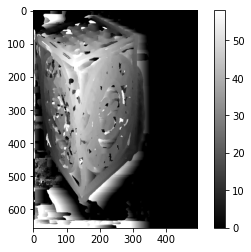

In [26]:
res = np.argmin(D, 2)
ppl.imshow(res,cmap='gray')
ppl.colorbar()

### 4.2 Estimación de la disparidad regularizada

El etiquetado usando exclusivamente términos unitarios
es muy sensible al ruido y propenso a que aparezcan zonas
de píxeles cercanos con mucha variación en las etiquetas.
Esto es especialmente notable en zonas planas (es decir, sin
textura) de las imágenes originales, donde no hay suficiente
información para establecer una correspondencia basándose
exclusivamente en la apariencia visual de ventanas pequeñas. Por eso es necesario incluir un término de suavizado
o regularización en la función de energía. Los tipos de
saltos de etiquetas que aparecerán en el resultado final
dependerán de cómo sea ese término de suavizado.

La función de energía que utilizaremos para calcular
las disparidades en la práctica será el resultado de añadir
a la expresión (6) un término que penalice los cambios de
disparidad en los píxeles vecinos: $$E_r(x) = \sum_{i} D_i(x_i) + \lambda\sum_{ij} \min(k,|x_i-x_j|).$$ Siendo $j$ los índices de los píxeles vecinos del $i$ en la imagen.
La solución al problema de la correspondencia vendrá dado
por el conjunto de etiquetas (disparidades) de los píxeles de
la imagen que minimicen $E_r(x)$.

En [Yuri Boykov, Olga Veksler, and Ramin Zabih. "Fast approximate
energy minimization via graph cuts". *IEEE Transactions on Pattern
Analysis and Machine Intelligence*, 23:1222–1239, 2001.] se presentan métodos para resolver algunos problemas de optimización con varias etiquetas empleando
algoritmos de cortes de grafos. Es recomendable repasar las
secciones 5 y 8.

**Ejercicio 17.** Escribe la función ``find_corresp_aexpansion(D, initLabels, lmb, maxV)``,
que recibe un volumen ssd, ``D``, un conjunto inicial de
etiquetas, ``initLabels``, que puede ser el obtenido en el
ejercicio 5, el valor de la constante $\lambda$, y el valor máximo
de la función de coste $|x_i − x_j|$, que tendrás que establecer empíricamente. El resultado de esta función serán las
etiquetas que minimizan $E_r(x)$. Para ello debes utilizar la función ``maxflow.fastmin.aexpansion_grid(D, V, max_cycles=None, labels=None)`` del paquete
*PyMaxFlow*, que resuelve el problema anterior mediante un
algoritmo de cortes de grafos empleando una $\alpha$-expansión.

In [33]:
def find_corresp_aexpansion(D, initialLabels, lmb, maxV):
    # Sacamos el número de posibles etiquetas
    num_labels = D.shape[2]
    # Creamos un matriz vacía cuadrada de dimensiones igual al 
    # número de etiquetas
    V = np.empty([num_labels, num_labels])
    
    for i in range(num_labels):   
        for j in range(num_labels):
            V[i, j] = min(lmb * np.abs(i - j), maxV)
        
    result = maxflow.fastmin.aexpansion_grid(D, V, max_cycles=None, labels=initialLabels)

    return result

Llama a esta función y muestra una figura con las etiquetas que resulten de la minimización de la energía para el volumen ssd ``D`` (este proceso puede durar varios minutos).

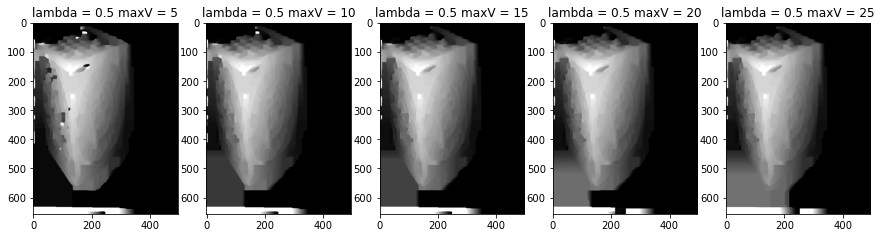

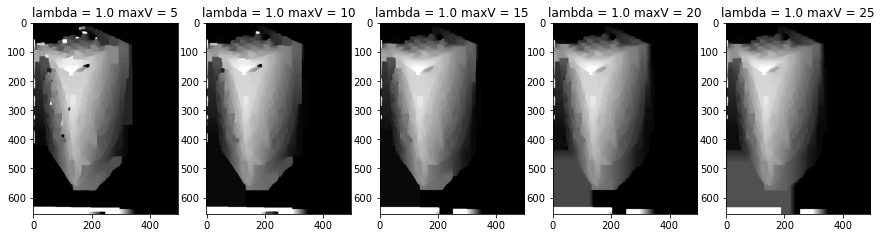

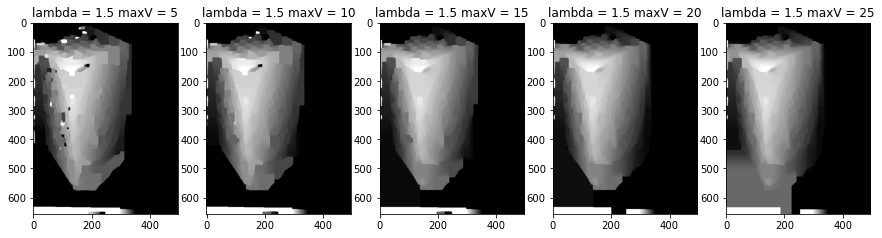

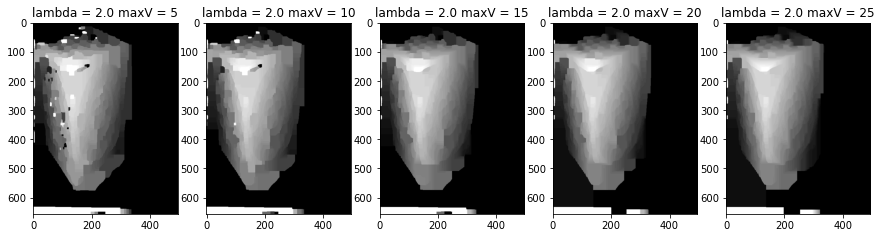

In [37]:
# labels = find_corresp_aexpansion(D, res, ... , ...)

lmb = [0.5, 1.0, 1.5, 2.0]
maxV = [5, 10, 15, 20, 25]

for i in lmb:
    f, axs = ppl.subplots(1, 5, figsize=(15,15))
    count = 0
    for j in maxV:
        labels = find_corresp_aexpansion(D, res, i, j)
        axs[count].set_title("lambda = {} maxV = {}".format(i,j))
        axs[count].imshow(labels, cmap='gray')
        count += 1
    ppl.show()

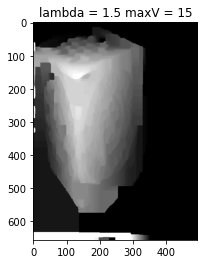

In [35]:
# Según las pruebas anteriores, uno de los mejores resultados 
# ha salido con los parámetros lambda = 1 y valor máximo 15
lmb = 1.5
maxV = 15
labels = find_corresp_aexpansion(D, res, lmb, maxV)

ppl.figure()
ppl.title("lambda = {} maxV = {}".format(lmb,maxV))
ppl.imshow(labels,cmap='gray')
ppl.show()

La matriz de etiquetas óptimas X obtenida de la minimización de la función de energía puede transformarse en
la matriz de disparidades S indexando en cada una de sus
celdas el array de disparidades disps ``S = disps[X]``.
Ahora, el píxel de coordenadas (x, y) de la primera imagen
rectificada tendrá su correspondencia en el píxel de coordenadas (x + S [y, x], y) de la segunda imagen rectificada.

El siguiente ejercicio usa la matriz de disparidades para
establecer automáticamente las correspondencias entre un
par de imágenes sin rectificar.

**Ejercicio 18.** Implementa la función
``plot_correspondences(image1, image2, S, H1,H2)``
que, dado un par de imágenes sin rectificar, la matriz de
disparidades entre las imágenes rectificadas y las homogra-
fías que llevan de las imágenes sin rectificar a las imágenes
rectificadas, pida al usuario puntos en la primera imagen y
dibuje sus correspondencias en la segunda.

In [53]:
def plot_correspondences(image1, image2, S, H1, H2):
    """
    Ask for points in the first image and plot their correspondences in
    the second image.
    
    Parameters
    ----------
    image1, image2 : array_like
        The images (before rectification)
    S : array_like
        The matrix of disparities.
    H1, H2 : array_like
        The homographies which rectify both images.
    """
    # Prepare the two images.
    fig = ppl.gcf()
    fig.clf()
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.imshow(image1)
    ax1.axis('image')
    ax2 = fig.add_subplot(1, 2, 2)
    ax2.imshow(image2)
    ax2.axis('image')
    ppl.draw()
    
    ax1.set_xlabel("Choose points in left image (or right click to end)")
    point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    while len(point) != 0:
        # point has the coordinates of the selected point in the first image.
        point = np.c_[np.array(point), 1].T
        ax1.plot(point[0,:], point[1,:], '.r')
        
        # Determine the correspondence of 'point' in the second image.
        # perhaps you have to swap the image co-ordinates.
        
        # Se calcula el punto rectificado y se pasa a coord. cartesianas
        r_point = H1 @ point
        point_c = r_point / r_point[2]
        
        d = S[int(point_c[1]), int(point_c[0])]
        point_c[0] -= d
        
        point_c = npla.pinv(H2) @ point_c
        point_c = (point_c / point_c[2])[:2]
        
        # Plot the correspondence with ax2.plot.
        ax2.plot(point_c[0], point_c[1] ,'r.')
        
        ppl.draw()
        # Ask for a new point.
        point = ppl.ginput(1, timeout=-1, show_clicks=False, mouse_pop=2, mouse_stop=3)
    
    ax1.set_xlabel('')
    ppl.draw()

In [67]:
S = disps[labels]
print(S)

[[139 139 139 ... 138 138 138]
 [139 139 139 ... 138 138 138]
 [139 139 139 ... 138 138 138]
 ...
 [196 196 196 ... 138 138 138]
 [196 196 196 ... 138 138 138]
 [196 196 196 ... 138 138 138]]


In [68]:
%matplotlib tk
plot_correspondences(img1, img2, S, H1, H2)

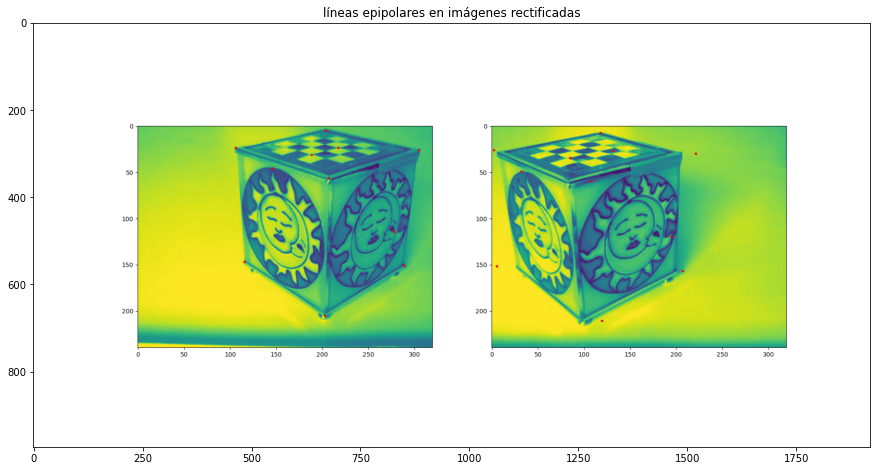

In [3]:
%matplotlib inline
ppl.figure(figsize=(15,10))
ppl.title("líneas epipolares en imágenes rectificadas")
ppl.imshow(cv2.cvtColor(cv2.imread(drivePrefix + "Figure_1_Ej18.png"), cv2.COLOR_BGR2RGB))
ppl.show()